<a href="https://colab.research.google.com/github/SergioDLezama/Retail-Analysis/blob/main/Predict_Customer_Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final model



In [82]:
# Git clone to get the data
!git clone https://github.com/SergioDLezama/Retail-Analysis

fatal: destination path 'Retail-Analysis' already exists and is not an empty directory.


Installing Scikeras and Keras-Tuner

In [83]:
#!pip install scikeras

In [84]:
#!pip install keras-tuner

In [85]:
#Importing necesary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kerastuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

from sklearn import metrics
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_curve

from scikeras.wrappers import KerasClassifier
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras import backend

import warnings
warnings.filterwarnings("ignore")

In [86]:
# Setting a style and number of Columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("whitegrid")
sns.set_palette('Blues_r')

In [87]:
# Importing the data
df = pd.read_csv('/content/Retail-Analysis/retail_data.csv')

In [88]:
# I a m not running this because it displays personal info as email
#df.head(3)

In [89]:
# Shape of the data before transforming. 302,010 Rows and 30 Columns
df.shape

(302010, 30)

In [90]:
# Description of the columns, there is some missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302010 entries, 0 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    301677 non-null  float64
 1   Customer_ID       301702 non-null  float64
 2   Name              301628 non-null  object 
 3   Email             301663 non-null  object 
 4   Phone             301648 non-null  float64
 5   Address           301695 non-null  object 
 6   City              301762 non-null  object 
 7   State             301729 non-null  object 
 8   Zipcode           301670 non-null  float64
 9   Country           301739 non-null  object 
 10  Age               301837 non-null  float64
 11  Gender            301693 non-null  object 
 12  Income            301720 non-null  object 
 13  Customer_Segment  301795 non-null  object 
 14  Date              301651 non-null  object 
 15  Year              301660 non-null  float64
 16  Month             30

In [91]:
# Amount of missing data per column
df.isnull().sum()

Transaction_ID      333
Customer_ID         308
Name                382
Email               347
Phone               362
Address             315
City                248
State               281
Zipcode             340
Country             271
Age                 173
Gender              317
Income              290
Customer_Segment    215
Date                359
Year                350
Month               273
Time                350
Total_Purchases     361
Amount              357
Total_Amount        350
Product_Category    283
Product_Brand       281
Product_Type          0
Feedback            184
Shipping_Method     337
Payment_Method      297
Order_Status        235
Ratings             184
products              0
dtype: int64

In [92]:
# Dropping rows with missing data
df = df.dropna()

In [93]:
# Checking if there is still missing data
df.isnull().sum()

Transaction_ID      0
Customer_ID         0
Name                0
Email               0
Phone               0
Address             0
City                0
State               0
Zipcode             0
Country             0
Age                 0
Gender              0
Income              0
Customer_Segment    0
Date                0
Year                0
Month               0
Time                0
Total_Purchases     0
Amount              0
Total_Amount        0
Product_Category    0
Product_Brand       0
Product_Type        0
Feedback            0
Shipping_Method     0
Payment_Method      0
Order_Status        0
Ratings             0
products            0
dtype: int64

In [94]:
# After dropping the missing and sensible data there is 293,911 rows and 24 columns
df.shape

(293911, 30)

In [95]:
# Dropping the columns that contain sensible data
cols_to_drop = ['Name', 'Email', 'Phone', 'Address', 'Zipcode','Time']
df = df.drop(cols_to_drop, axis=1)

In [96]:
# Quick view of the data
df.head(3)

,Transaction_ID,Customer_ID,City,State,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.00,37249.00,Dortmund,Berlin,Germany,21.00,Male,Low,Regular,9/18/2023,2023.00,September,3.00,108.03,324.09,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.00,Cycling shorts
1,2174773.00,69749.00,Nottingham,England,UK,19.00,Female,Low,Premium,12/31/2023,2023.00,December,2.00,403.35,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00,Lenovo Tab
2,6679610.00,30192.00,Geelong,New South Wales,Australia,48.00,Male,Low,Regular,4/26/2023,2023.00,April,3.00,354.48,1063.43,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.00,Sports equipment


In [97]:
# Statistical description of the numerical columns on the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction_ID,293911.00,5493725.59,2596085.94,1000007.00,3245885.50,5495879.00,7738197.00,9999995.00
Customer_ID,293911.00,55013.40,26009.44,10000.00,32470.00,55027.00,77514.00,99999.00
Age,293911.00,35.47,15.02,18.00,22.00,32.00,46.00,70.00
Year,293911.00,2023.17,0.37,2023.00,2023.00,2023.00,2023.00,2024.00
Total_Purchases,293911.00,5.36,2.87,1.00,3.00,5.00,8.00,10.00
Amount,293911.00,255.15,141.39,10.00,132.84,255.46,377.64,500.00
Total_Amount,293911.00,1367.69,1128.90,10.00,438.85,1041.16,2028.95,4999.63
Ratings,293911.00,3.16,1.32,1.00,2.00,3.00,4.00,5.00


In [98]:
# There is 3 duplicated rows
df.duplicated().sum()

3

In [99]:
# Getting the indexes
dup = df.duplicated()
df[dup].index

Index([299759, 301362, 301486], dtype='int64')

In [100]:
# Dropping the duplicated
df = df.drop(df.index[dup])

In [101]:
df.duplicated().sum()

0

In [102]:
df.shape

(293908, 24)

In [103]:
# The transaction IDs are not unique which is a problem
df['Transaction_ID'].nunique()

287005

In [104]:
# There is multiple transactions with the same ID
df['Transaction_ID'].value_counts()

Transaction_ID
6145934.00    4
9918529.00    3
6592672.00    3
1858467.00    3
2452608.00    3
             ..
4487444.00    1
6826016.00    1
2050516.00    1
6943631.00    1
9099074.00    1
Name: count, Length: 287005, dtype: int64

In [105]:
'''
Clearly there is some transaction IDs duplicated, but i do not know which one is the real
 so i will drop all the transaction IDs that appear more than 1 time
'''
df[df['Transaction_ID']==6145934]

,Transaction_ID,Customer_ID,City,State,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
140676,6145934.00,76353.00,Hamilton,Ontario,Canada,26.00,Male,Medium,Regular,11/29/2023,2023.00,January,3.00,146.11,438.34,Electronics,Whirepool,Fridge,Good,Express,Credit Card,Delivered,3.00,French door refrigerator
194626,6145934.00,23433.00,Bochum,Berlin,Germany,22.00,Female,Low,Regular,3/24/2023,2023.00,March,1.00,180.74,180.74,Home Decor,Bed Bath & Beyond,Bedding,Bad,Same-Day,Credit Card,Delivered,1.00,Pillowcase set
300648,6145934.00,76353.00,Hamilton,Ontario,Canada,56.00,Male,Medium,Premium,11/29/2023,2023.00,November,3.00,146.11,438.34,Clothing,Zara,Dress,Good,Express,Cash,Pending,4.00,Casual dress
301371,6145934.00,23433.00,Bochum,Berlin,Germany,22.00,Female,Low,Regular,3/24/2023,2023.00,March,1.00,180.74,180.74,Home Decor,Bed Bath & Beyond,Bedding,Bad,Same-Day,Cash,Delivered,1.00,Throw pillow


In [106]:
# Dropping duplicated IDs
duplicate_transaction_ids = df['Transaction_ID'].value_counts()[lambda x: x > 1].index
duplicate_indexes = df[df['Transaction_ID'].isin(duplicate_transaction_ids)].index
df = df.drop(duplicate_indexes)

In [107]:
# All the transaction IDs are unique
df['Transaction_ID'].value_counts()

Transaction_ID
2174773.00    1
2416371.00    1
5736738.00    1
5060644.00    1
2195548.00    1
             ..
3897203.00    1
2970871.00    1
3374752.00    1
9948479.00    1
9099074.00    1
Name: count, Length: 280216, dtype: int64

In [108]:
# Resetting the Index
df = df.reset_index(drop=True)

In [109]:
# We are left with 280,216 rows and 24 columns
df.shape

(280216, 24)

In [110]:
# Columns to drop, they do not provide information for the model
cols_to_drop = [
    'Transaction_ID', 'Customer_ID', 'City', 'State', 'Date', 'Year', 'Month', 'Amount', 'products'
]
df = df.drop(cols_to_drop, axis=1)

In [111]:
df.head(1)

,Country,Age,Gender,Income,Customer_Segment,Total_Purchases,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings
0,UK,19.00,Female,Low,Premium,2.00,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00


In [112]:
# I just need Regular and Premium Customers
df.Customer_Segment.value_counts()

Customer_Segment
Regular    136207
New         84609
Premium     59400
Name: count, dtype: int64

In [113]:
# Filtered Dataframe
df_filtered = df[df['Customer_Segment'].isin(['Regular', 'Premium'])]
df_filtered.head()

,Country,Age,Gender,Income,Customer_Segment,Total_Purchases,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings
0,UK,19.00,Female,Low,Premium,2.00,806.71,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.00
1,Australia,48.00,Male,Low,Regular,3.00,1063.43,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.00
2,Canada,56.00,Male,High,Premium,7.00,2466.85,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.00
3,UK,22.00,Male,Low,Premium,2.00,248.55,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.00
4,Australia,58.00,Female,Medium,Premium,4.00,1185.17,Electronics,Apple,Tablet,Good,Express,PayPal,Pending,4.00


In [114]:
df_filtered.Customer_Segment.value_counts()

Customer_Segment
Regular    136207
Premium     59400
Name: count, dtype: int64

In [115]:
# Encoding the target. Regular = 0 / Premium = 1
df_filtered['Customer_Segment'] = df_filtered['Customer_Segment'].map({'Regular': 0, 'Premium': 1})

print(df_filtered['Customer_Segment'].value_counts())

Customer_Segment
0    136207
1     59400
Name: count, dtype: int64


In [116]:
# Define the features and target
X = df_filtered.drop(columns=['Customer_Segment'])
y = df_filtered['Customer_Segment']

print(X.shape, y.shape)

(195607, 14) (195607,)


In [117]:
# Identify categorical and numerical columns
categorical_columns = ['Country', 'Gender', 'Product_Category', 'Product_Brand', 'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status', 'Income']
numerical_columns = ['Age', 'Total_Purchases', 'Total_Amount', 'Ratings']

# Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns)  # Set sparse_output to False
    ]
)

# Apply the transformations
X_processed = preprocessor.fit_transform(X)

# Verify the processed feature shape. 195,607 rows and 85 columns
print(X_processed.shape)

(195607, 85)


In [118]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Verify the shapes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(156485, 85) (39122, 85) (156485,) (39122,)


### Necesary Functions

In [119]:
# History plot, to visualize how the model is learning
def plot_history_accuracy(history):

  # Plotting training & validation accuracy values
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], color = 'red')
  plt.plot(history.history['val_accuracy'], color = 'blue')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plotting training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], color= 'red')
  plt.plot(history.history['val_loss'], color= 'blue')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

In [120]:
# Confusion Matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='mako',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)


    if title:
        plt.title(title)

In [121]:
# Clear session
backend.clear_session()
np.random.seed(7)
import random
random.seed(7)
tf.random.set_seed(7)

In [122]:
# Creating the model. Has 7 layers
best_model = Sequential()

best_model.add(Dense(176, input_dim=X_train.shape[1], activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(16, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(48, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(176, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(144, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(176, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(16, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(1, activation='sigmoid'))

In [123]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 176)                 │          15,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           2,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 48)                  │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 176)                 │           8,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 144)                 │          25,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 176)                 │          25,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           2,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,265 (317.44 KB)

 Trainable params: 81,265 (317.44 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Setting the optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(0.0001)
best_model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [125]:
# Fit the model
model_history = best_model.fit(X_train,y_train,batch_size=64,epochs=150,verbose=0,validation_split = 0.2)

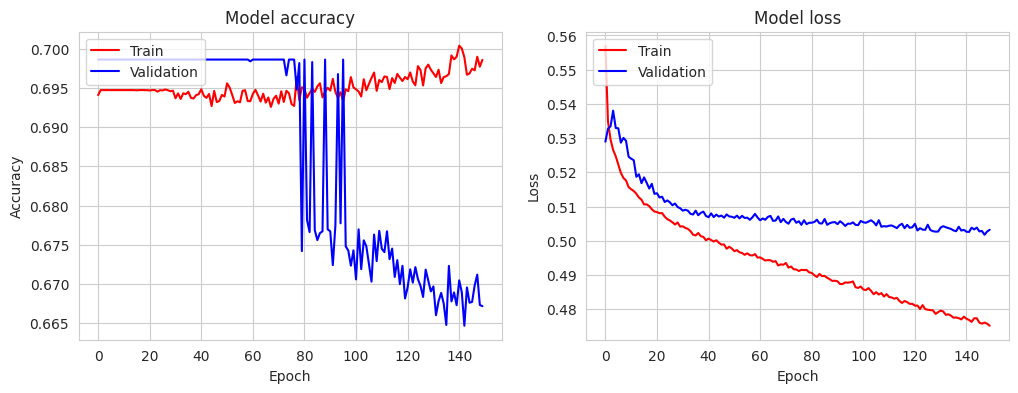

In [126]:
# Visualizing model loss and accuracy
plot_history_accuracy(model_history)

1223/1223 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Best Threshold=0.392123, G-Mean=0.689


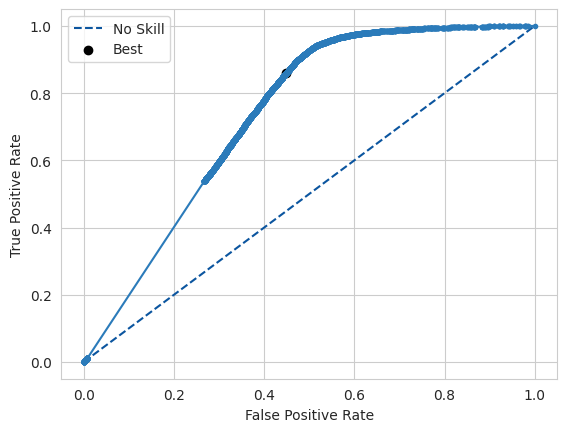

In [127]:
# Plot to find the best threshold

# predict probabilities
yhat = best_model.predict(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [128]:
y_pred_e= best_model.predict(X_test)
y_pred_e = (y_pred_e > thresholds[ix])

1223/1223 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


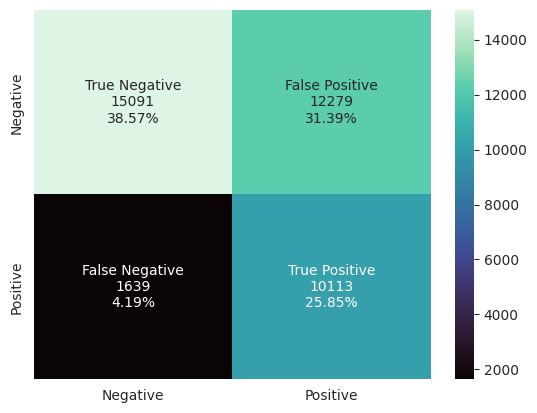

In [129]:
#Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm9=confusion_matrix(y_test, y_pred_e)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Negative','Positive']
make_confusion_matrix(cm9,
                      group_names=labels,
                      categories=categories,
                      cmap='mako')

In [130]:
# Visual report. Really good predicting regular customers, not so good with premium customers
Confusion=metrics.classification_report(y_test,y_pred_e)
print(Confusion)

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     27370
           1       0.45      0.86      0.59     11752

    accuracy                           0.64     39122
   macro avg       0.68      0.71      0.64     39122
weighted avg       0.77      0.64      0.66     39122



In [131]:
# Dataframe with only New customers
new_customers = df[df['Customer_Segment'].isin(['New'])]

In [132]:
new_customers['Customer_Segment'].value_counts()

Customer_Segment
New    84609
Name: count, dtype: int64

In [133]:
# Dropping customer segment
new_customers = new_customers.drop(['Customer_Segment'], axis=1)

In [134]:
# Identify categorical and numerical columns
categorical_columns = ['Country', 'Gender', 'Product_Category', 'Product_Brand', 'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status', 'Income']
numerical_columns = ['Age', 'Total_Purchases', 'Total_Amount', 'Ratings']

# Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns)  # Set sparse_output to False
    ]
)

# Apply the transformations
new_customers_prepared = preprocessor.fit_transform(new_customers)

# Verify the processed feature shape
print(new_customers_prepared.shape)

(84609, 85)


In [135]:
# Predict probabilities
y_new_pred_prob = best_model.predict(new_customers_prepared)

# Since we have a sigmoid activation function, the output is the probability of being 'Premium'
# We can round these probabilities to get the class predictions (0 for 'Regular', 1 for 'Premium')
y_new_pred_class = (y_new_pred_prob > thresholds[ix]).astype(int)

# Add predictions to the new customers DataFrame
new_customers['Probability_Premium'] = y_new_pred_prob
new_customers['Predicted_Class'] = y_new_pred_class

# Map the predicted class to 'Regular' and 'Premium'
new_customers['Predicted_Class'] = new_customers['Predicted_Class'].map({0: 'Regular', 1: 'Premium'})

# Display the results
new_customers

2645/2645 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


,Country,Age,Gender,Income,Total_Purchases,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,Probability_Premium,Predicted_Class
5,Canada,29.00,Female,Low,2.00,630.12,Electronics,Samsung,Television,Bad,Standard,Cash,Processing,1.00,0.51,Premium
7,Australia,46.00,Male,Medium,8.00,2630.71,Grocery,Nestle,Chocolate,Bad,Same-Day,Cash,Delivered,1.00,0.37,Regular
8,Germany,25.00,Male,Medium,10.00,3976.11,Home Decor,Home Depot,Decorations,Excellent,Standard,Cash,Delivered,4.00,0.41,Premium
16252,UK,19.00,Female,Medium,1.00,309.78,Electronics,Apple,Smartphone,Good,Express,Cash,Delivered,3.00,0.03,Regular
16253,UK,19.00,Male,Medium,5.00,2368.73,Clothing,Adidas,T-shirt,Bad,Express,PayPal,Delivered,1.00,0.01,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280200,Australia,25.00,Male,Low,6.00,196.73,Grocery,Nestle,Snacks,Average,Same-Day,Credit Card,Shipped,2.00,0.51,Premium
280201,UK,30.00,Male,High,2.00,37.34,Home Decor,Home Depot,Furniture,Bad,Same-Day,Credit Card,Pending,1.00,0.51,Premium
280205,UK,44.00,Female,Low,4.00,69.33,Home Decor,IKEA,Decorations,Average,Same-Day,Credit Card,Pending,2.00,0.39,Regular
280209,Australia,63.00,Male,Low,6.00,2357.11,Books,Penguin Books,Children's,Excellent,Standard,Credit Card,Processing,5.00,0.51,Premium


In [136]:
# Visualizing the probabilities. The highest is 0.51
new_customers['Probability_Premium'].value_counts()

Probability_Premium
0.51    34241
0.51        4
0.51        3
0.51        3
0.51        3
        ...  
0.33        1
0.06        1
0.05        1
0.50        1
0.37        1
Name: count, Length: 49509, dtype: int64

In [137]:
'''
The model predicted
62261 Premium customers. with close to 50% accuracy we can say that half of the predicted customers are Premium
22348 Regular customers. with close to 90% accuracy we can say that most of the predicted customers are Regular
'''
new_customers['Predicted_Class'].value_counts()

Predicted_Class
Premium    62261
Regular    22348
Name: count, dtype: int64

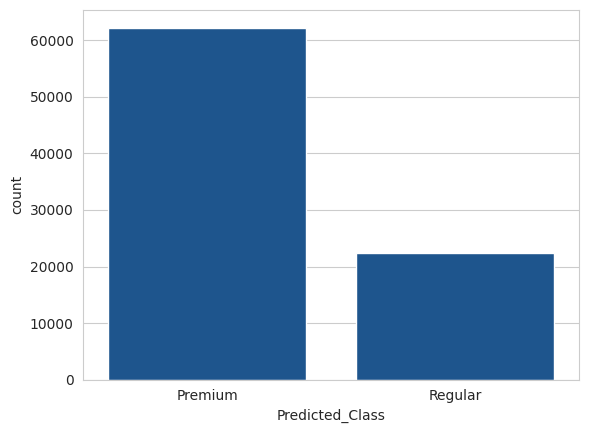

In [138]:
# Plot of the predicted classes
sns.countplot(x='Predicted_Class', data=new_customers)
plt.show()

In [139]:
# Saving the data
new_customers.to_csv('new_customers_predicted.csv', index=False)